<a href="https://colab.research.google.com/github/Pooret/inspiritai/blob/main/Copy_of_Copy_2of_Oversampling_2dUNet_CT_Scans_Tyler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, concatenate, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
import gdown
from ipywidgets import interact, IntSlider
from scipy.ndimage import zoom
from PIL import Image
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
import os
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!unzip /content/gdrive/MyDrive/data3/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1.zip

unzip:  cannot find or open /content/gdrive/MyDrive/data3/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1.zip, /content/gdrive/MyDrive/data3/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1.zip.zip or /content/gdrive/MyDrive/data3/computed-tomography-images-for-intracranial-hemorrhage-detection-and-segmentation-1.3.1.zip.ZIP.


In [4]:
# This code loads the CT slices (grayscale images) of the brain-window for each subject in ct_scans folder then saves them to
# one folder (data\image).
# Their segmentation from the masks folder is saved to another folder (data\label).
import os
from pathlib import Path
import numpy as np
import pandas as pd
import nibabel as nib
from PIL import Image
import matplotlib.pyplot as plt
def window_ct(ct_scan, w_level=40, w_width=120):
    w_min = w_level - w_width / 2
    w_max = w_level + w_width / 2
    num_slices = ct_scan.shape[2]

    for s in range(num_slices):
        slice_s = ct_scan[:, :, s]
        slice_s = (slice_s - w_min) * (255 / (w_max - w_min))
        slice_s[slice_s < 0] = 0
        slice_s[slice_s > 255] = 255
        ct_scan[:, :, s] = slice_s

    return ct_scan

numSubj = 82
new_size = (256, 256) # Change this if RAM runs out!
window_specs = [40, 120]
currentDir = Path(os.getcwd())
datasetDir = str(currentDir) + "/gdrive/MyDrive/Datasets/ct-ich"

# Reading labels
hemorrhage_diagnosis_df = pd.read_csv(Path(currentDir,'/content/gdrive/MyDrive/Datasets/ct-ich/hemorrhage_diagnosis_raw_ct.csv'))
hemorrhage_diagnosis_array = hemorrhage_diagnosis_df.values

# Reading images
train_path = Path('data')
image_path = train_path / 'image'
label_path = train_path / 'label'

if not train_path.exists():
    train_path.mkdir()
    image_path.mkdir()
    label_path.mkdir()

counterI = 0
for sNo in range(49, numSubj + 49):
    if 58 < sNo < 66:
        continue

    # Loading the CT scan
    ct_dir_subj = Path(datasetDir, 'ct_scans', f"{sNo:03d}.nii")
    ct_scan_nifti = nib.load(str(ct_dir_subj))
    ct_scan = ct_scan_nifti.get_fdata()
    ct_scan = window_ct(ct_scan, window_specs[0], window_specs[1])

    # Loading the masks
    masks_dir_subj = Path(datasetDir, 'masks', f"{sNo:03d}.nii")
    masks_nifti = nib.load(str(masks_dir_subj))
    masks = masks_nifti.get_fdata()

    idx = hemorrhage_diagnosis_array[:, 0] == sNo
    sliceNos = hemorrhage_diagnosis_array[idx, 1]
    NoHemorrhage = hemorrhage_diagnosis_array[idx, 7]

    if sliceNos.size != ct_scan.shape[2]:
        print('Warning: the number of annotated slices does not equal the number of slices in NIFTI file!')

    for sliceI in range(sliceNos.size):
        # Saving a given CT slice
        x = Image.fromarray(np.uint8(ct_scan[:, :, sliceI]))
        x = x.resize(new_size)
        x.save(image_path / f"{counterI}.png")

        # Saving the segmentation for a given slice
        x = Image.fromarray(np.uint8(masks[:, :, sliceI]))
        x = x.resize(new_size)
        x.save(label_path / f"{counterI}.png")

        counterI += 1

In [5]:
print(f"Number of patients: {len(hemorrhage_diagnosis_df.groupby('PatientNumber').count())}")
print(f"Number of slices: {len(hemorrhage_diagnosis_df)}")
print(f"Avg. number of slices per patient: {hemorrhage_diagnosis_df.groupby('PatientNumber')['SliceNumber'].count().mean()}")

Number of patients: 75
Number of slices: 2814
Avg. number of slices per patient: 37.52


In [6]:
hemorrhage_diagnosis_df.head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No
0,49,1,0,0,0,0,0,1,0
1,49,2,0,0,0,0,0,1,0
2,49,3,0,0,0,0,0,1,0
3,49,4,0,0,0,0,0,1,0
4,49,5,0,0,0,0,0,1,0


In [8]:
hemorrhage_diagnosis_df['No_Hemorrhage'].value_counts()

No_Hemorrhage
1    2496
0     318
Name: count, dtype: int64

In [9]:
img_dir = "/content/data/image"
mask_dir = "/content/data/label"
num_images = len(os.listdir(img_dir))
assert num_images == len(os.listdir(mask_dir))
print("number of images: ", num_images)

number of images:  2814


In [10]:
hemorrhage_diagnosis_df['image_path'] = [f'/content/data/image/{i}.png' for i in range(num_images)]
hemorrhage_diagnosis_df['mask_path'] = [f'/content/data/label/{i}.png' for i in range(num_images)]
hemorrhage_diagnosis_df.head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No,image_path,mask_path
0,49,1,0,0,0,0,0,1,0,/content/data/image/0.png,/content/data/label/0.png
1,49,2,0,0,0,0,0,1,0,/content/data/image/1.png,/content/data/label/1.png
2,49,3,0,0,0,0,0,1,0,/content/data/image/2.png,/content/data/label/2.png
3,49,4,0,0,0,0,0,1,0,/content/data/image/3.png,/content/data/label/3.png
4,49,5,0,0,0,0,0,1,0,/content/data/image/4.png,/content/data/label/4.png


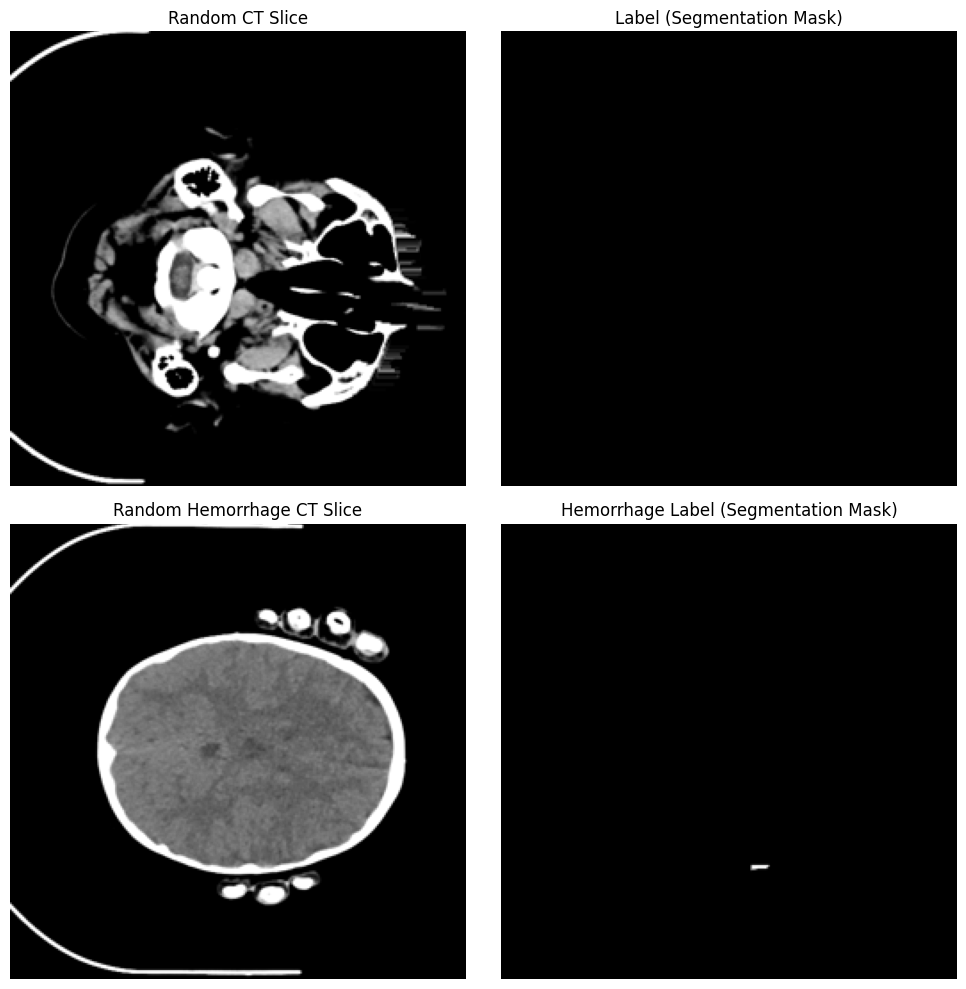

In [12]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Generate random integer for indexing
rand_idx = np.random.randint(num_images - 1)

# Images with hemorrhage samples
hem_idx = hemorrhage_diagnosis_df[hemorrhage_diagnosis_df['No_Hemorrhage'] == 0].sample(n=1).index.item()

# Replace these paths with the actual paths to your processed images and labels
sample_ct_image_path = f'/content/data/image/{rand_idx}.png'
sample_label_path = f'/content/data/label/{rand_idx}.png'

hem_ct_image_path = f'/content/data/image/{hem_idx}.png'
hem_label_path = f'/content/data/label/{hem_idx}.png'

# Load the sample CT image and label
ct_image = Image.open(sample_ct_image_path)
label_image = Image.open(sample_label_path)

# Load the hemorrhage CT image and label
hem_ct_image = Image.open(hem_ct_image_path)
hem_label_image = Image.open(hem_label_path)

# Convert images to numpy arrays for visualization (optional)
ct_image_array = np.array(ct_image)
label_image_array = np.array(label_image)

hem_ct_image_array = np.array(hem_ct_image)
hem_label_image_array = np.array(hem_label_image)

# Display using matplotlib
fig, axes = plt.subplots(2, 2, figsize=(10, 10))  # Adjusted to 2 rows and 2 columns

# Plot random sample
axes[0, 0].imshow(ct_image_array, cmap='gray')
axes[0, 0].set_title('Random CT Slice')
axes[0, 0].axis('off')

axes[0, 1].imshow(label_image_array, cmap='gray')
axes[0, 1].set_title('Label (Segmentation Mask)')
axes[0, 1].axis('off')

# Plot hemorrhage sample
axes[1, 0].imshow(hem_ct_image_array, cmap='gray')
axes[1, 0].set_title('Random Hemorrhage CT Slice')
axes[1, 0].axis('off')

axes[1, 1].imshow(hem_label_image_array, cmap='gray')
axes[1, 1].set_title('Hemorrhage Label (Segmentation Mask)')
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()


In [23]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.image as mpimg

# Split the dataframe into train and test sets
train_df, val_df = train_test_split(hemorrhage_diagnosis_df, test_size=0.1, random_state=42)

minority_df = hemorrhage_diagnosis_df[hemorrhage_diagnosis_df['No_Hemorrhage'] == 0]
balanced_df = pd.concat([minority_df, hemorrhage_diagnosis_df[hemorrhage_diagnosis_df['No_Hemorrhage'] == 1].sample(n=len(minority_df))])

train_df, val_df = train_test_split(balanced_df, test_size=0.1, random_state=42)

from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

def random_rotation(x):
    # Custom rotation logic, if needed, can be added here
    return x

def add_elastic_transform(image, alpha_range, sigma, random_state=None):
    """Add elastic transformation to augment data."""
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    dx = random_state.rand(*shape) * 2 - 1
    dy = random_state.rand(*shape) * 2 - 1
    dx *= alpha_range * shape[1]
    dy *= alpha_range * shape[0]

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    distored_image = map_coordinates(image, indices, order=1, mode='reflect')
    return distored_image

# Define an ImageDataGenerator for training with extended augmentation
train_datagen = ImageDataGenerator(
    rotation_range=50,        # Increase the degree range for rotation
    width_shift_range=0.35,   # Increase shift range horizontally
    height_shift_range=0.35,  # Increase shift range vertically/..
    shear_range=0.35,         # Increase shear intensity
    zoom_range=0.35,           # Increase zoom range
    horizontal_flip=True,     # Allow horizontal flipping
    vertical_flip=True,
    zca_whitening=True,
    zca_epsilon=1e-06,# Allow vertical flipping (if it makes sense for your data)
    fill_mode='nearest',
    preprocessing_function=add_elastic_transform  # Apply elastic deformation
)

validation_datagen = ImageDataGenerator(rescale=1.0)

def create_generator(dataframe, datagen, batch_size=32, target_size=(256, 256)):
    """Custom generator that yields a tuple (images, masks) suitable for model training/validation."""
    while True:
        # Shuffle dataframe in each epoch
        #dataframe = dataframe.sample(frac=1).reset_index(drop=True)

        # Generate batches
        for start in range(0, len(dataframe), batch_size):
            end = min(start + batch_size, len(dataframe))
            batch_items = dataframe[start:end]

            images = []
            masks = []
            for _, row in batch_items.iterrows():
                img = load_img(row['image_path'], color_mode='grayscale', target_size=target_size)
                mask = load_img(row['mask_path'], color_mode='grayscale', target_size=target_size)

                img_array = img_to_array(img) / 255.0
                mask_array = img_to_array(mask) / 255.0

                images.append(img_array)
                masks.append(mask_array)

            images = np.array(images)
            masks = np.array(masks)

            yield images, masks

# Create training and validation generators

#train_generator = create_generator(balanced_df, train_datagen, batch_size=batch_size)
train_generator = create_generator(train_df, train_datagen, batch_size=batch_size)
validation_generator = create_generator(val_df, validation_datagen, batch_size=batch_size)

# Check generator output
images, masks = next(train_generator)
print("Images batch shape:", images.shape)  # Expected: (32, 256, 256, 1)
print("Masks batch shape:", masks.shape)  # Expected: (32, 256, 256, 1)


# Check generator output
batch = next(train_generator)  # Get the first batch
images, masks = batch  # Unpack the batch into images and masks
print("Images batch shape:", images.shape)  # Expected: (32, 256, 256, 1)
print("Masks batch shape:", masks.shape)  # Expected: (32, 256, 256, 1)

if images.shape[1] != 256 or images.shape[2] != 256:
    raise ValueError("Input images are not 256x256 in size.")
else:
    print("Input images are correctly sized.")


Images batch shape: (32, 256, 256, 1)
Masks batch shape: (32, 256, 256, 1)
Images batch shape: (32, 256, 256, 1)
Masks batch shape: (32, 256, 256, 1)
Input images are correctly sized.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1444: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn(


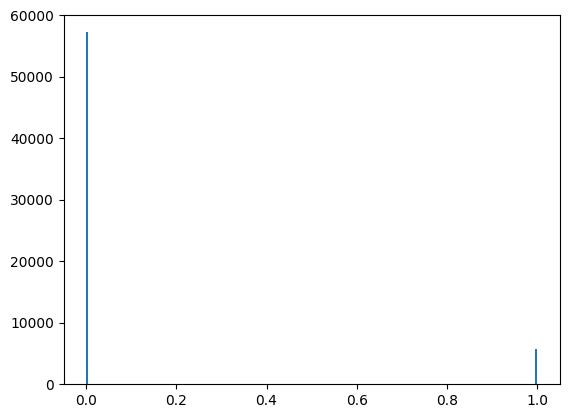

In [24]:
plt.hist(images[0].flatten(),bins = 256)
plt.show()

In [25]:
# Check generator output
print(f"batch size: {batch_size}")
batch = next(train_generator)  # Get the first batch
print(f"batch type: {type(batch)}")  # Check the type of the batch
print(f"num elements per batch: {len(batch)}")  # Check the length of the batch, if it's a tuple or list

if len(batch) == 2:
    print("Elements in batch:")
    images, masks = batch # extract elements from batch
    print("\tImages batch shape:", images.shape)  # Expected: (32, 256, 256, 1)
    print("\tMasks batch shape:", masks.shape)  # Expected: (32, 256, 256, 1)
else:
    print("Batch does not contain exactly two elements. Check generator configuration.")


batch size: 32
batch type: <class 'tuple'>
num elements per batch: 2
Elements in batch:
	Images batch shape: (32, 256, 256, 1)
	Masks batch shape: (32, 256, 256, 1)


In [26]:
NUM_FILTERS = 32
DROPOUT_RATE = .1
BATCH_SIZE = 32

import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Activation, BatchNormalization, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate


import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Activation, BatchNormalization, Dropout
from tensorflow.keras.models import Model

def conv_block(input_tensor, num_filters, dropout_rate):
    x = Conv2D(num_filters, (3, 3), padding="same")(input_tensor)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rate)(x)
    return x
def dense_block(input_tensor, num_layers, num_filters, dropout_rate):
    x = input_tensor
    concat_layers = [x]
    for _ in range(num_layers):
        conv = conv_block(x, num_filters, dropout_rate)
        concat_layers.append(conv)
        x = Concatenate()(concat_layers)
    return x


def encoder_block(input_tensor, num_filters, dropout_rate):
    x = conv_block(input_tensor, num_filters, dropout_rate)
    p = MaxPooling2D((2, 2))(x)
    return p, x

def decoder_block(input_tensor, concat_tensor, num_filters, dropout_rate):
    x = UpSampling2D((2, 2))(input_tensor)
    x = concatenate([x, concat_tensor], axis=-1)
    x = conv_block(x, num_filters, dropout_rate)
    return x

def unet(input_shape=(256, 256, 1), num_filters_base=16, dropout_rate=0.5):
    inputs = Input(input_shape)

    # Encoder
    e1_pool, e1 = encoder_block(inputs, num_filters_base, dropout_rate)
    e2_pool, e2 = encoder_block(e1_pool, num_filters_base*2, dropout_rate)
    e3_pool, e3 = encoder_block(e2_pool, num_filters_base*4, dropout_rate)
    e4_pool, e4 = encoder_block(e3_pool, num_filters_base*8, dropout_rate) # New deeper layer
 # New deeper layer

    # Bridge
    b = dense_block(e4_pool, 4,num_filters_base*16, dropout_rate)

    # Decoder # Adjusted to match the new layer
    d3 = decoder_block(b, e4, num_filters_base*8, dropout_rate)
    d2 = decoder_block(d3, e3, num_filters_base*4, dropout_rate)
    d1 = decoder_block(d2, e2, num_filters_base*2, dropout_rate)
    d0 = decoder_block(d1, e1, num_filters_base, dropout_rate)  # Existing layers

    # Output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(d0)
    model = Model(inputs=inputs, outputs=outputs)
    return model

# Loss and metrics
def dice_loss(y_true, y_pred, smooth=5.0):
    y_true_f = tf.cast(y_true, tf.float32)
    y_pred_f = tf.cast(y_pred, tf.float32)
    numerator = 2 * tf.reduce_sum(y_true_f * y_pred_f) + smooth
    denominator = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    return 1 - numerator / (denominator + tf.keras.backend.epsilon())

def binary_iou(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = intersection / (union + tf.keras.backend.epsilon())
    return iou

def combined_loss(y_true, y_pred):
    return 0.5 * tf.keras.losses.binary_crossentropy(y_true, y_pred) + 0.5 * dice_loss(y_true, y_pred)

# Create the model
from tensorflow.keras.optimizers import AdamW, Adagrad, Nadam, SGD, RMSprop

learning_rate = 0.001

adamw = AdamW(learning_rate=learning_rate, weight_decay=0.0001)
sgd_opt = SGD(learning_rate=learning_rate, momentum=.9)
rms_opt = RMSprop(learning_rate=0.001)
model = unet(num_filters_base=NUM_FILTERS, dropout_rate=DROPOUT_RATE)
model.compile(optimizer=rms_opt, loss=combined_loss, metrics=[binary_iou, dice_loss])

# Model summary
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d_13 (Conv2D)          (None, 256, 256, 32)         320       ['input_2[0][0]']             
                                                                                                  
 activation_12 (Activation)  (None, 256, 256, 32)         0         ['conv2d_13[0][0]']           
                                                                                                  
 batch_normalization_12 (Ba  (None, 256, 256, 32)         128       ['activation_12[0][0]']       
 tchNormalization)                                                                          

In [27]:
# Verifying input dimensions just before model training
for images, masks in train_generator:
    if images.shape[1] != 256 or images.shape[2] != 256:
        raise ValueError("Input images are not 256x256 in size.")
    break  # Checking the first batch only for quick verification


Epoch 1/150
17/17 [==============================] - ETA: 0s - loss: 0.8554 - binary_iou: 0.0057 - dice_loss: 0.9923
Epoch 1: val_loss improved from inf to 0.78543, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


17/17 [==============================] - 19s 824ms/step - loss: 0.8554 - binary_iou: 0.0057 - dice_loss: 0.9923 - val_loss: 0.7854 - val_binary_iou: 0.0000e+00 - val_dice_loss: 0.9907
Epoch 2/150
17/17 [==============================] - ETA: 0s - loss: 0.8014 - binary_iou: 0.0091 - dice_loss: 0.9915
Epoch 2: val_loss improved from 0.78543 to 0.76952, saving model to best_model.h5
17/17 [==============================] - 14s 803ms/step - loss: 0.8014 - binary_iou: 0.0091 - dice_loss: 0.9915 - val_loss: 0.7695 - val_binary_iou: 0.0000e+00 - val_dice_loss: 0.9906
Epoch 3/150
17/17 [==============================] - ETA: 0s - loss: 0.7721 - binary_iou: 0.0156 - dice_loss: 0.9906
Epoch 3: val_loss improved from 0.76952 to 0.72278, saving model to best_model.h5
17/17 [==============================] - 14s 810ms/step - loss: 0.7721 - binary_iou: 0.0156 - dice_loss: 0.9906 - val_loss: 0.7228 - val_binary_iou: 0.0000e+00 - val_dice_loss: 0.9906
Epoch 4/150
17/17 [==============================]

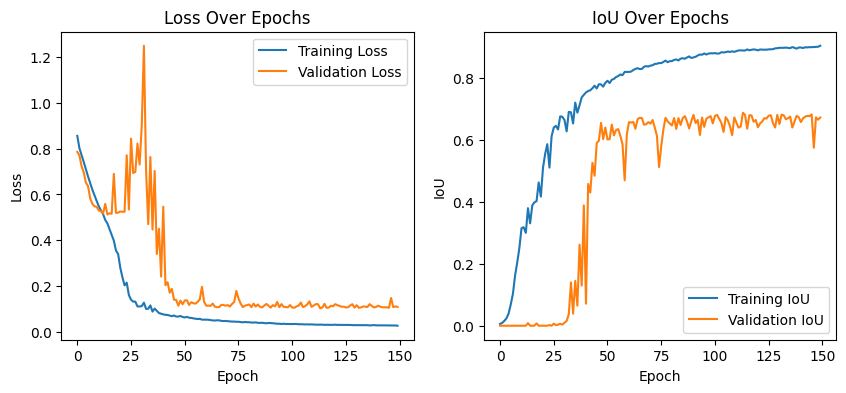

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Define the checkpoint to save the best model
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Set up early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience= 50,
    verbose=1,
    mode='min',
    start_from_epoch=50
)

# Set up reduce learning rate on plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    verbose=1,
    mode='min',
    min_lr=0.00001
)
def moving_avg(data, window_size):
    cumulative_sum = np.cumsum(np.insert(data, 0, 0))
    return (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size

history = model.fit(
    train_generator,
    steps_per_epoch=len(train_df) // BATCH_SIZE,
    epochs=150,
    validation_data=validation_generator,
    validation_steps=len(val_df) // BATCH_SIZE,
    callbacks=[checkpoint] #
)

# After training, plot the history of your training and validation to evaluate performance
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['binary_iou'], label='Training IoU')  # Adjust based on the actual metrics you have
plt.plot(history.history['val_binary_iou'], label='Validation IoU')  # Adjust the key if necessary
plt.title('IoU Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.show()


In [30]:
def moving_avg(data, window_size):
    cumulative_sum = np.cumsum(np.insert(data, 0, 0))
    return (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size

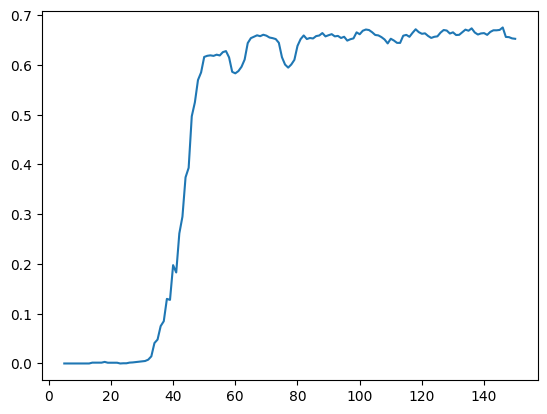

In [31]:
window_size=5

epochs = range(window_size, len(history.history['val_binary_iou'])+1)

plt.plot(epochs,moving_avg(history.history['val_binary_iou'], window_size=window_size))

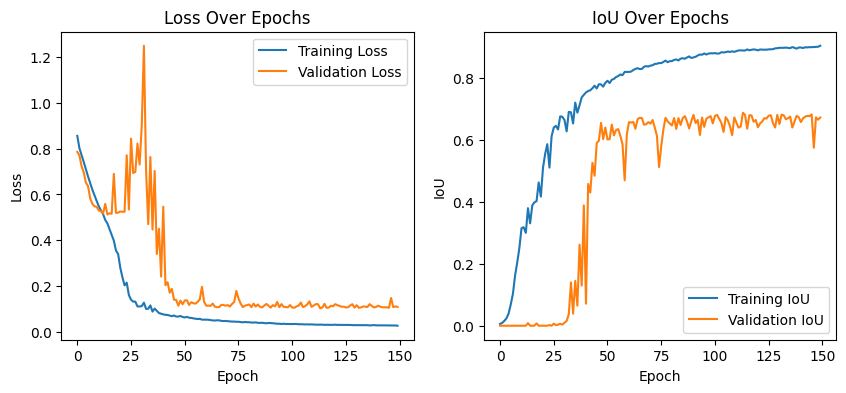

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['binary_iou'], label='Training IoU')  # Adjust based on the actual metrics you have
plt.plot(history.history['val_binary_iou'], label='Validation IoU')  # Adjust the key if necessary
plt.title('IoU Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()

plt.show()

1/1 [==============================] - 0s 253ms/step


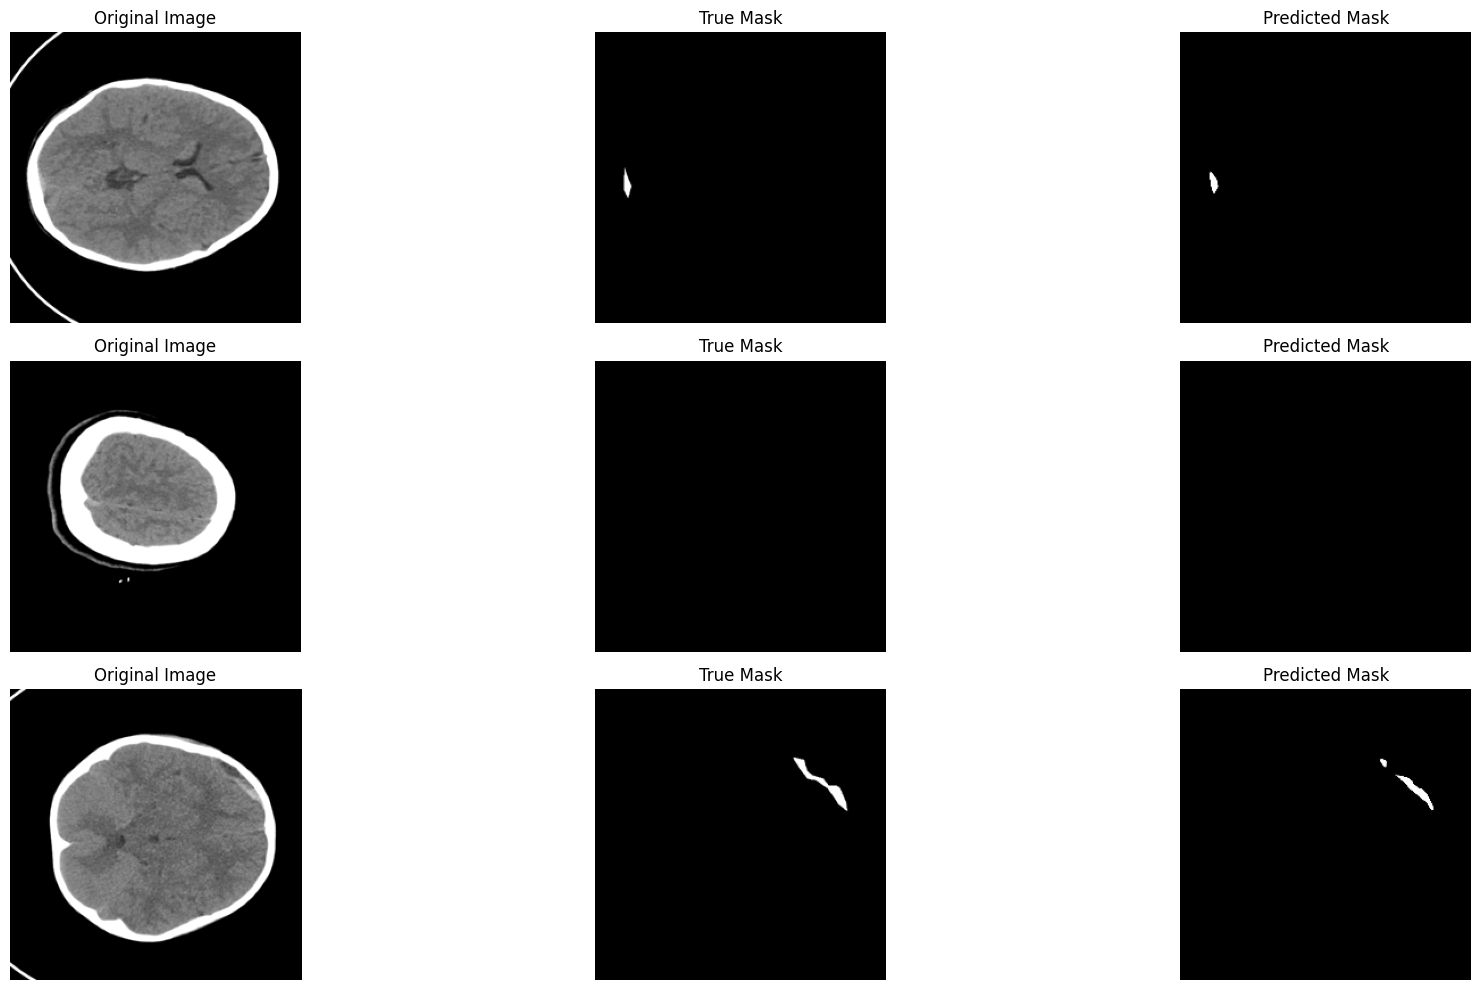

1/1 [==============================] - 0s 22ms/step


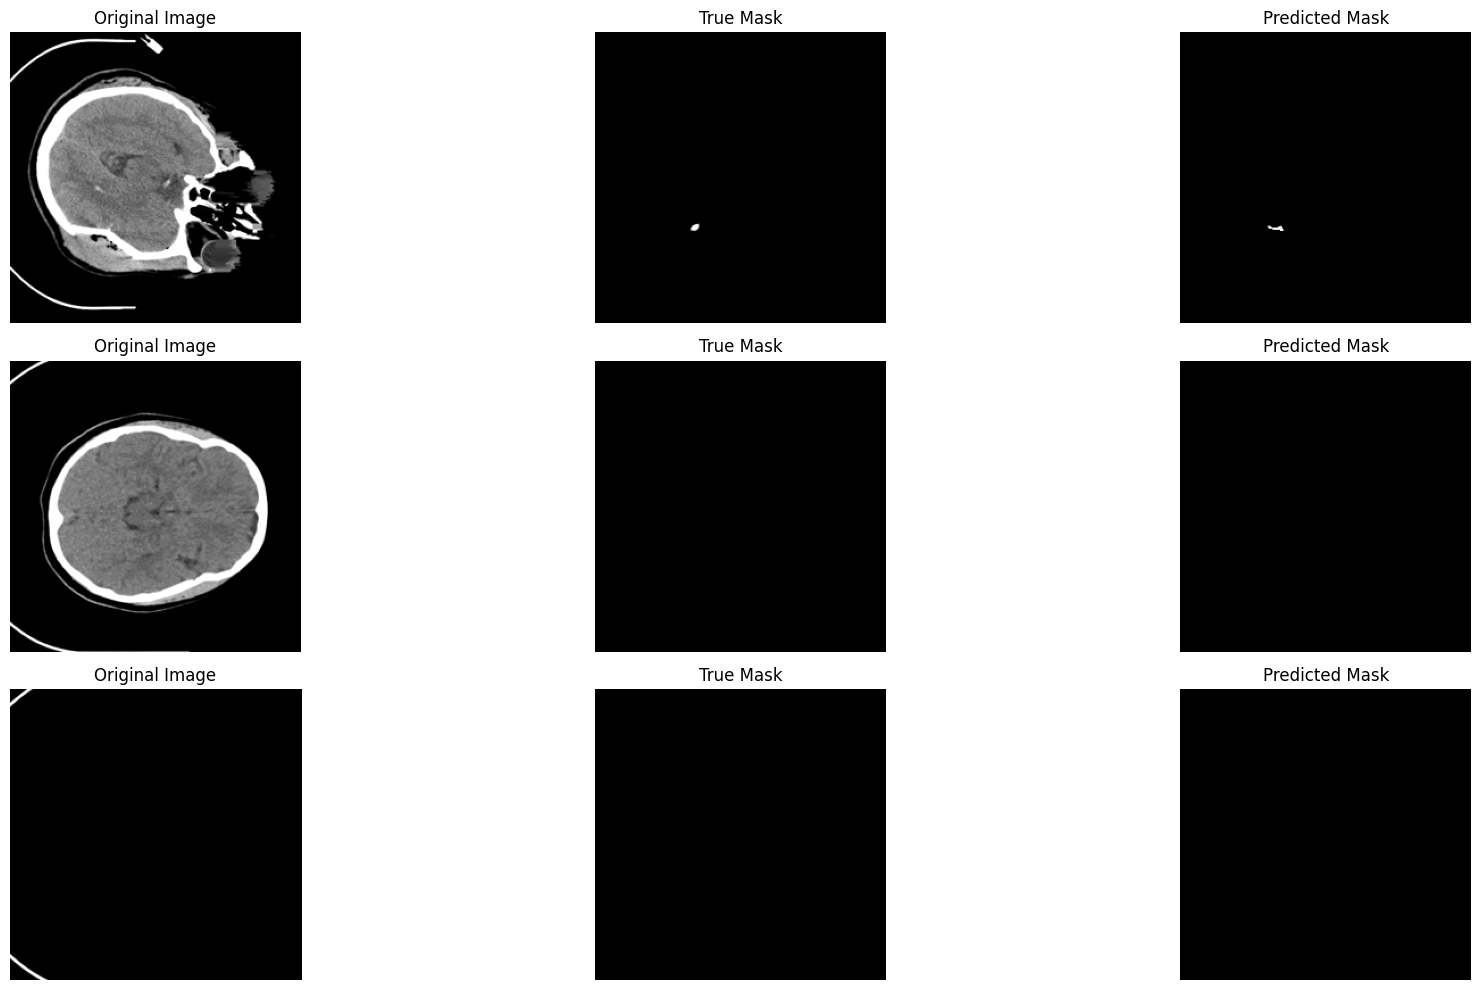

1/1 [==============================] - 0s 23ms/step


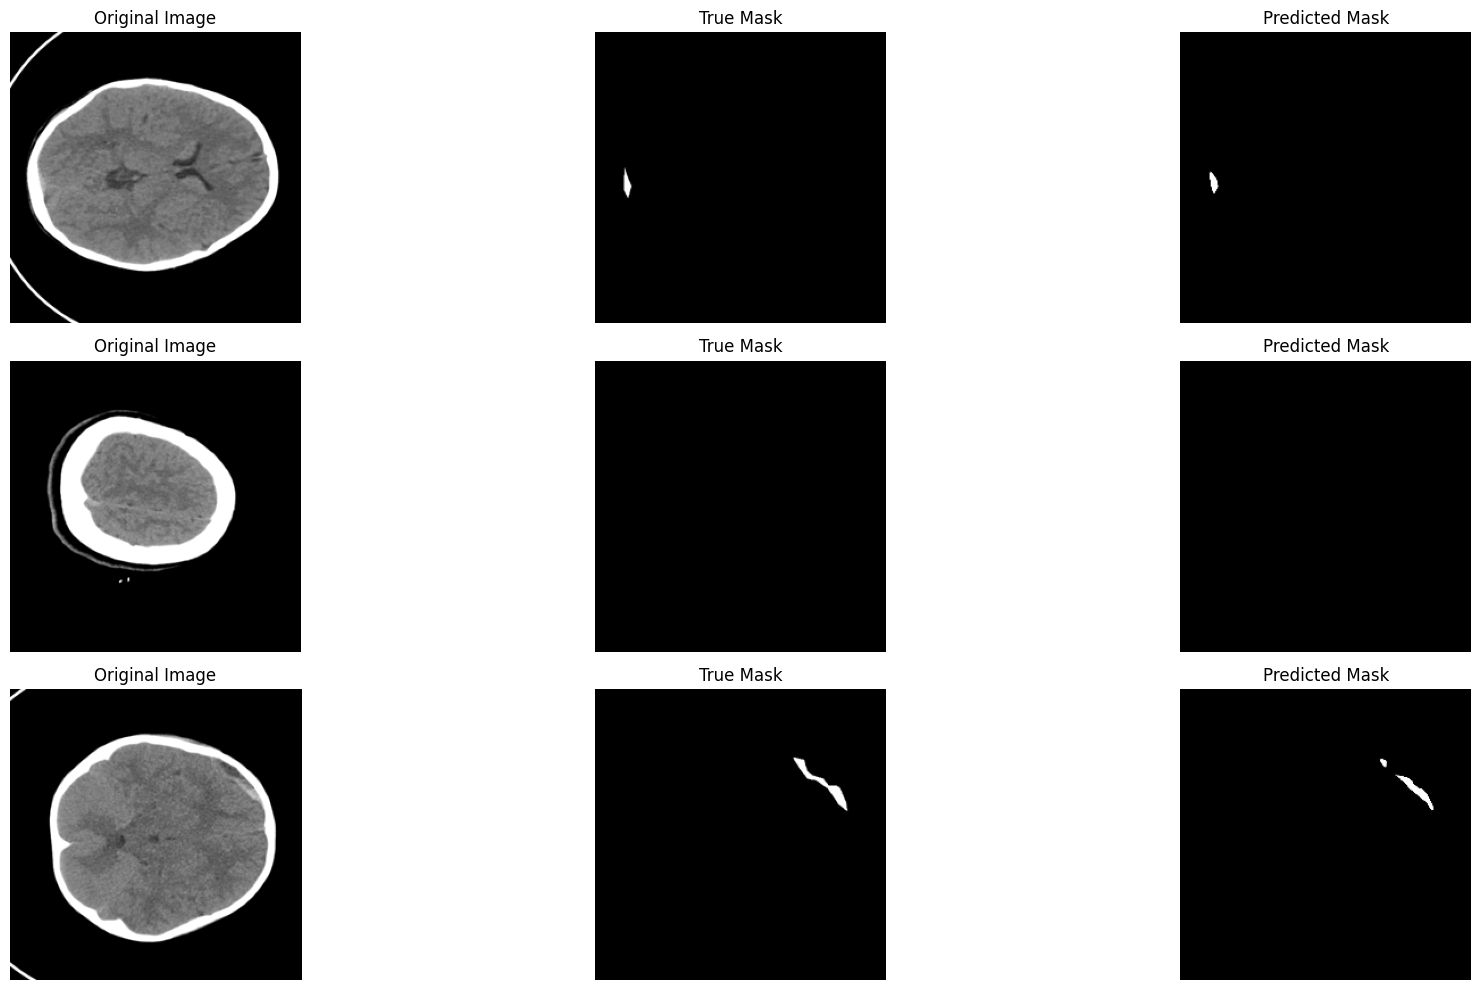

In [33]:
def plot_predictions(model, generator, num_samples=3):
    # Fetch a batch of data from the generator
    for i, (images, masks) in enumerate(generator):
        if i >= num_samples:  # Only predict a few samples
            break
        preds = model.predict(images)

        fig, axes = plt.subplots(num_samples, 3, figsize=(20, 10))
        for j in range(num_samples):
            axes[j, 0].imshow(images[j], cmap='gray')
            axes[j, 0].set_title('Original Image')
            axes[j, 1].imshow(masks[j].squeeze(), cmap='gray')
            axes[j, 1].set_title('True Mask')
            axes[j, 2].imshow(preds[j].squeeze(), cmap='gray', vmin=0, vmax=1)
            axes[j, 2].set_title('Predicted Mask')

        for ax in axes.flat:
            ax.axis('off')

        plt.tight_layout()
        plt.show()

# Assuming 'validation_generator' yields (images, masks)
plot_predictions(model, validation_generator)